# Rehab Strength Dashboard – EDA Baseline

## Purpose
This notebook establishes the exploratory data analysis (EDA) foundation
for understanding training load, sleep behavior, and recovery signals
during rehabilitation.

The goal is not prediction, but clarity:
- What is normal?
- What is noise?
- What could indicate risk?


## Data Dictionary Reference

The full data dictionary for this project is maintained in:

`data_schema/data_dictionary.md`

This notebook assumes the definitions, granularity,
and limitations described there.


In [64]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## WORKOUTS

In [65]:
workouts = pd.read_csv("/Users/polux9589/Desktop/gym-ml-performance/data/raw/strong.csv")   #Upload workouts data
workouts.info()

<class 'pandas.DataFrame'>
RangeIndex: 6327 entries, 0 to 6326
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           6327 non-null   str    
 1   Workout Name   6327 non-null   str    
 2   Duration       6327 non-null   str    
 3   Exercise Name  6327 non-null   str    
 4   Set Order      6327 non-null   str    
 5   Weight         6327 non-null   float64
 6   Reps           6327 non-null   float64
 7   Distance       6327 non-null   int64  
 8   Seconds        6327 non-null   float64
 9   Notes          185 non-null    str    
 10  Workout Notes  0 non-null      float64
 11  RPE            4458 non-null   float64
dtypes: float64(5), int64(1), str(6)
memory usage: 593.3 KB


In [66]:
workouts.columns

Index(['Date', 'Workout Name', 'Duration', 'Exercise Name', 'Set Order',
       'Weight', 'Reps', 'Distance', 'Seconds', 'Notes', 'Workout Notes',
       'RPE'],
      dtype='str')

In [67]:
workouts.describe(include="all")

,Date,Workout Name,Duration,Exercise Name,Set Order,Weight,Reps,Distance,Seconds,Notes,Workout Notes,RPE
count,6327,6327,6327,6327,6327,6327.000000,6327.000000,6327.0,6327.000000,185,0.0,4458.000000
unique,199,17,61,70,11,NaN,NaN,NaN,NaN,37,NaN,NaN
top,2025-12-19 10:49:20,CHEST & BACK,1h 25m,Incline Bench Press (Barbell),Rest Timer,NaN,NaN,NaN,NaN,Machine brand: LifeFitness,NaN,NaN
freq,67,984,332,327,1615,NaN,NaN,NaN,NaN,46,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,67.315157,7.954481,0.0,34.392919,NaN,NaN,8.022880
std,NaN,NaN,NaN,NaN,NaN,67.659043,5.259003,0.0,59.984666,NaN,NaN,1.079067
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,NaN,NaN,6.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,NaN,NaN,7.000000
50%,NaN,NaN,NaN,NaN,NaN,50.000000,10.000000,0.0,0.000000,NaN,NaN,8.000000
75%,NaN,NaN,NaN,NaN,NaN,105.000000,12.000000,0.0,100.000000,NaN,NaN,9.000000


In [68]:
workouts.shape

(6327, 12)

In [69]:
workouts["Date"]= pd.to_datetime(workouts["Date"], format="%Y-%m-%d %H:%M:%S")
workouts["Date"] = workouts["Date"].dt.date
workouts["Date"]

0       2024-09-22
1       2024-09-22
2       2024-09-22
3       2024-09-22
4       2024-09-22
           ...    
6322    2026-01-26
6323    2026-01-26
6324    2026-01-26
6325    2026-01-26
6326    2026-01-26
Name: Date, Length: 6327, dtype: object

## SLEEP

In [70]:
sleep = pd.read_excel("/Users/polux9589/Desktop/gym-ml-performance/data/raw/Sleep_Garmin.xlsx")  #Upload sleep data
sleep.info()

<class 'pandas.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Sleep Score 4 Weeks  42 non-null     datetime64[us]
 1   Score                42 non-null     int64         
 2   Resting Heart Rate   42 non-null     int64         
 3   Body Battery         42 non-null     int64         
 4   Pulse Ox             42 non-null     str           
 5   Respiration          42 non-null     float64       
 6   HRV Status           42 non-null     int64         
 7   Quality              42 non-null     str           
 8   Duration             42 non-null     str           
 9   Sleep Need           42 non-null     str           
 10  Bedtime              42 non-null     object        
 11  Wake Time            42 non-null     object        
dtypes: datetime64[us](1), float64(1), int64(4), object(2), str(4)
memory usage: 4.1+ KB


In [71]:
sleep.shape

(42, 12)

In [72]:
sleep.columns

Index(['Sleep Score 4 Weeks', 'Score', 'Resting Heart Rate', 'Body Battery',
       'Pulse Ox', 'Respiration', 'HRV Status', 'Quality', 'Duration',
       'Sleep Need', 'Bedtime', 'Wake Time'],
      dtype='str')

In [73]:
sleep.sample(10)

,Sleep Score 4 Weeks,Score,Resting Heart Rate,Body Battery,Pulse Ox,Respiration,HRV Status,Quality,Duration,Sleep Need,Bedtime,Wake Time
14,2025-12-30,87,43,57,--,15.08,46,Good,7h 51min,8h 0min,23:19:00,07:15:00
31,2026-01-16,79,41,49,93.85,14.78,46,Fair,6h 12min,8h 0min,00:30:00,06:46:00
40,2026-01-25,87,42,58,94.38,15.67,47,Good,7h 49min,7h 0min,23:00:00,07:00:00
4,2025-12-20,91,43,63,--,14.75,44,Excellent,7h 55min,8h 0min,22:22:00,06:20:00
15,2025-12-31,87,44,64,--,14.96,46,Good,7h 27min,8h 0min,23:09:00,06:40:00
9,2025-12-25,78,42,58,--,14.45,46,Fair,6h 8min,8h 0min,01:39:00,07:49:00
22,2026-01-07,88,42,58,--,15.40,48,Good,7h 44min,8h 0min,22:29:00,06:15:00
27,2026-01-12,87,42,54,92.39,14.71,47,Good,7h 34min,7h 30min,22:46:00,06:30:00
11,2025-12-27,63,44,30,--,16.58,46,Fair,5h 24min,8h 0min,00:03:00,06:15:00
6,2025-12-22,86,42,45,--,15.25,43,Good,7h 50min,8h 0min,23:56:00,07:50:00


In [74]:
sleep.describe(include="all")

,Sleep Score 4 Weeks,Score,Resting Heart Rate,Body Battery,Pulse Ox,Respiration,HRV Status,Quality,Duration,Sleep Need,Bedtime,Wake Time
count,42,42.000000,42.000000,42.000000,42,42.000000,42.000000,42,42,42,42,42
unique,NaN,NaN,NaN,NaN,15,NaN,NaN,3,39,9,36,34
top,NaN,NaN,NaN,NaN,--,NaN,NaN,Good,8h 3min,8h 0min,22:00:00,06:15:00
freq,NaN,NaN,NaN,NaN,26,NaN,NaN,25,2,24,3,5
mean,2026-01-12 00:00:00,84.214286,42.666667,54.619048,NaN,15.417381,46.333333,NaN,NaN,NaN,NaN,NaN
min,2025-12-16 00:00:00,63.000000,40.000000,30.000000,NaN,14.450000,43.000000,NaN,NaN,NaN,NaN,NaN
25%,2025-12-26 06:00:00,79.250000,42.000000,51.000000,NaN,14.925000,46.000000,NaN,NaN,NaN,NaN,NaN
50%,2026-01-05 12:00:00,86.000000,42.500000,54.000000,NaN,15.460000,46.000000,NaN,NaN,NaN,NaN,NaN
75%,2026-01-15 18:00:00,87.000000,43.000000,58.000000,NaN,15.785000,47.000000,NaN,NaN,NaN,NaN,NaN
max,2026-10-22 00:00:00,98.000000,48.000000,68.000000,NaN,16.810000,48.000000,NaN,NaN,NaN,NaN,NaN


## HRV

In [75]:
hrv = pd.read_excel("/Users/polux9589/Desktop/gym-ml-performance/data/raw/HRV_Status.xlsx")  #Upload HRV data
hrv.info()

<class 'pandas.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           42 non-null     datetime64[us]
 1   Overnight HRV  42 non-null     str           
 2   Baseline       42 non-null     str           
 3   7d Avg         42 non-null     str           
 4   Stress         41 non-null     float64       
 5   RHR            42 non-null     int64         
dtypes: datetime64[us](1), float64(1), int64(1), str(3)
memory usage: 2.1 KB


In [76]:
hrv.columns

Index(['Date', 'Overnight HRV', 'Baseline', '7d Avg', 'Stress', 'RHR'], dtype='str')

In [77]:
hrv.shape

(42, 6)

In [78]:
hrv.describe(include="all")

,Date,Overnight HRV,Baseline,7d Avg,Stress,RHR
count,42,42,42,42,41.000000,42.000000
unique,NaN,14,5,6,NaN,NaN
top,NaN,47ms,45ms - 53ms,46ms,NaN,NaN
freq,NaN,5,18,14,NaN,NaN
mean,2026-01-05 12:00:00,NaN,NaN,NaN,25.804878,42.666667
min,2025-12-16 00:00:00,NaN,NaN,NaN,19.000000,40.000000
25%,2025-12-26 06:00:00,NaN,NaN,NaN,23.000000,42.000000
50%,2026-01-05 12:00:00,NaN,NaN,NaN,25.000000,42.500000
75%,2026-01-15 18:00:00,NaN,NaN,NaN,29.000000,43.000000
max,2026-01-26 00:00:00,NaN,NaN,NaN,38.000000,48.000000


# DAY 2

In [79]:
trim_mean = stats.trim_mean(sleep["Score"], proportiontocut=0.1)
trim_mean

np.float64(84.38235294117646)

In [80]:
mean = sleep["Score"].mean()
mean

np.float64(84.21428571428571)

In [81]:
median = sleep["Score"].median()
median

np.float64(86.0)

In [82]:
weighted_mean = np.average(sleep["Score"], weights=sleep["HRV Status"])
weighted_mean

np.float64(84.21017471736896)

In [83]:
std_score = sleep["Score"].std(ddof=1)
std_score

np.float64(6.30344742798351)

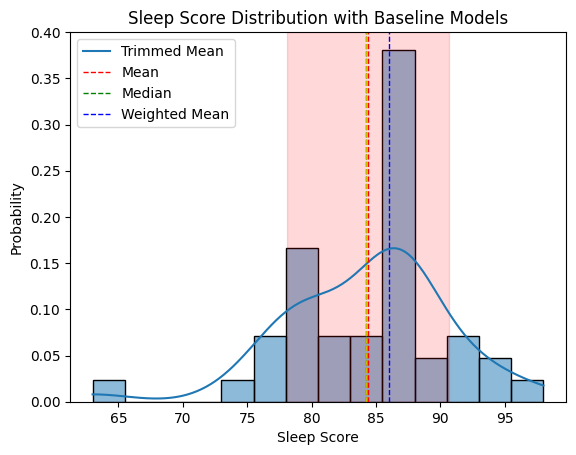

In [84]:
sns.histplot(sleep["Score"], kde=True, stat="probability", binwidth=2.5)
plt.axvline(trim_mean, color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(median, color='b', linestyle='dashed', linewidth=1)
plt.axvline(weighted_mean, color='y', linestyle='dashed', linewidth=1)
plt.axvspan(trim_mean - std_score, trim_mean + std_score, alpha=0.15, color='r')
plt.legend({'Trimmed Mean':trim_mean,'Mean':mean,'Median':median,'Weighted Mean':weighted_mean})
plt.title('Sleep Score Distribution with Baseline Models')
plt.xlabel('Sleep Score')
plt.ylabel('Probability')
plt.show()

In [85]:
def normality_test(data):
    stat, pvalue = stats.shapiro(data)
    if pvalue > 0.05:
        return print(f"The data follows a normal distribution (fail to reject H0) {pvalue:.5f}")
    else:
        return print(f"The data does not follow a normal distribution (reject H0) {pvalue:.5f}")

normality_test(sleep["Score"])

The data does not follow a normal distribution (reject H0) 0.02495


In [86]:
sleep = sleep.rename(columns={"Sleep Score 4 Weeks":"Date"})
sleep.info()

<class 'pandas.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                42 non-null     datetime64[us]
 1   Score               42 non-null     int64         
 2   Resting Heart Rate  42 non-null     int64         
 3   Body Battery        42 non-null     int64         
 4   Pulse Ox            42 non-null     str           
 5   Respiration         42 non-null     float64       
 6   HRV Status          42 non-null     int64         
 7   Quality             42 non-null     str           
 8   Duration            42 non-null     str           
 9   Sleep Need          42 non-null     str           
 10  Bedtime             42 non-null     object        
 11  Wake Time           42 non-null     object        
dtypes: datetime64[us](1), float64(1), int64(4), object(2), str(4)
memory usage: 4.1+ KB


In [87]:
sleep["HRV Status"].describe()

count    42.000000
mean     46.333333
std       1.300406
min      43.000000
25%      46.000000
50%      46.000000
75%      47.000000
max      48.000000
Name: HRV Status, dtype: float64

In [88]:
mean_hrv = sleep["HRV Status"].mean()
weighted_mean_hrv = np.average(sleep["HRV Status"], weights=sleep["Score"])
trim_mean_hrv = stats.trim_mean(sleep["HRV Status"], proportiontocut=0.1)
median_hrv = sleep["HRV Status"].median()
std_hrv = sleep["HRV Status"].std(ddof=1)

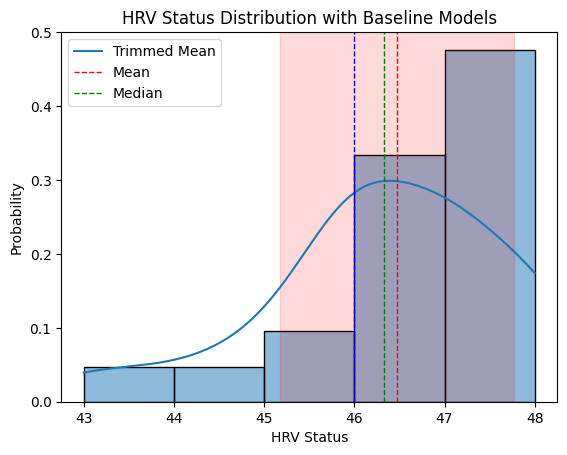

The data does not follow a normal distribution (reject H0) 0.00079


In [89]:
sns.histplot(sleep["HRV Status"], kde=True, stat="probability", binwidth=1)
plt.axvline(trim_mean_hrv, color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean_hrv, color='g', linestyle='dashed', linewidth=1)
plt.axvline(median_hrv, color='b', linestyle='dashed', linewidth=1)
plt.axvspan(trim_mean_hrv - std_hrv, trim_mean_hrv + std_hrv, alpha=0.15, color='r')
plt.legend({'Trimmed Mean':trim_mean_hrv,'Mean':mean_hrv,'Median':median_hrv})
plt.title('HRV Status Distribution with Baseline Models')
plt.xlabel('HRV Status')
plt.ylabel('Probability')
plt.show()

normality_test(sleep["HRV Status"])

In [90]:
test = pd.read_csv("/Users/polux9589/Desktop/GYM WORKOUT ANALYSIS PROJECT/processed_data/clean_sleep_data.csv")

In [91]:
test.columns

Index(['Date', 'Main_x', 'Start', 'End', 'InBed hrs', 'Asleep hrs', 'Awake',
       'REM hrs', 'Light hrs', 'Deep hrs', 'Wake Count', 'Efficiency',
       'Fall Asleep', 'Data Source', 'Main_y', 'Start_Nap', 'End_Nap',
       'Asleep_Nap', 'Data Source Nap', 'Overnight HRV', 'Baseline', '7d Avg',
       'Stress', 'RHR'],
      dtype='str')

In [92]:
test.info()

<class 'pandas.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             432 non-null    str    
 1   Main_x           432 non-null    bool   
 2   Start            432 non-null    str    
 3   End              432 non-null    str    
 4   InBed hrs        432 non-null    float64
 5   Asleep hrs       432 non-null    float64
 6   Awake            432 non-null    int64  
 7   REM hrs          330 non-null    float64
 8   Light hrs        332 non-null    float64
 9   Deep hrs         332 non-null    float64
 10  Wake Count       432 non-null    int64  
 11  Efficiency       432 non-null    str    
 12  Fall Asleep      329 non-null    float64
 13  Data Source      432 non-null    str    
 14  Main_y           26 non-null     object 
 15  Start_Nap        26 non-null     str    
 16  End_Nap          26 non-null     str    
 17  Asleep_Nap       26 non-nul

In [93]:
test.describe()

,InBed hrs,Asleep hrs,Awake,REM hrs,Light hrs,Deep hrs,Wake Count,Fall Asleep,Asleep_Nap,Overnight HRV,7d Avg,Stress,RHR
count,432.000000,432.000000,432.000000,330.000000,332.000000,332.000000,432.000000,329.000000,26.000000,42.000000,42.000000,42.000000,42.000000
mean,7.408372,7.093094,18.236111,1.625404,4.178564,1.610542,3.145833,0.319149,38.230769,46.142857,46.333333,25.714286,42.666667
std,1.399238,1.276616,29.800182,0.558949,0.883473,0.383891,4.321159,5.788837,28.273391,3.523935,1.300406,4.522495,1.408453
min,4.450000,2.083333,0.000000,0.116667,2.033333,0.000000,0.000000,0.000000,15.000000,39.000000,43.000000,19.000000,40.000000
25%,6.408333,6.212500,1.000000,1.266667,3.616667,1.383333,1.000000,0.000000,25.250000,43.250000,46.000000,23.000000,42.000000
50%,7.275000,7.016667,9.000000,1.608333,4.100000,1.650000,2.000000,0.000000,30.000000,46.500000,46.000000,24.500000,42.500000
75%,8.104167,7.866667,22.250000,1.933333,4.700000,1.866667,4.000000,0.000000,30.000000,49.000000,47.000000,28.750000,43.000000
max,15.050000,11.766667,265.000000,3.633333,7.016667,2.633333,34.000000,105.000000,158.000000,52.000000,48.000000,38.000000,48.000000


In [94]:
sleep

,Date,Score,Resting Heart Rate,Body Battery,Pulse Ox,Respiration,HRV Status,Quality,Duration,Sleep Need,Bedtime,Wake Time
0,2025-12-16,79,43,54,--,15.46,48,Fair,6h 57min,8h 0min,22:00:00,05:05:00
1,2025-12-17,83,45,63,--,15.64,47,Good,8h 31min,8h 0min,22:11:00,06:54:00
2,2025-12-18,80,44,55,--,15.29,47,Good,6h 34min,7h 0min,22:31:00,05:06:00
3,2025-12-19,82,44,55,--,15.46,45,Good,7h 2min,7h 40min,23:16:00,06:45:00
4,2025-12-20,91,43,63,--,14.75,44,Excellent,7h 55min,8h 0min,22:22:00,06:20:00
5,2025-12-21,87,43,66,--,15.70,43,Good,8h 1min,8h 0min,22:53:00,07:00:00
6,2025-12-22,86,42,45,--,15.25,43,Good,7h 50min,8h 0min,23:56:00,07:50:00
7,2025-12-23,87,44,62,--,15.61,44,Good,7h 37min,8h 20min,22:27:00,06:13:00
8,2025-12-24,74,42,53,--,14.67,45,Fair,6h 15min,8h 0min,23:16:00,06:15:00
9,2025-12-25,78,42,58,--,14.45,46,Fair,6h 8min,8h 0min,01:39:00,07:49:00
